<img src="Quora_1.png">

<h1 style="text-align:center;font-size:30px;" > Quora Question Pairs </h1>

<h1> 1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 


__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

<h2> 1.2 Sources/Useful Links</h2>

- Source : https://www.kaggle.com/c/quora-question-pairs
<br><br>____ Useful Links ____
- Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
- Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

<h2>1.3 Real world/Business Objectives and Constraints </h2>

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

<h1>2. Machine Learning Probelm </h1>

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

<h3> 2.1.2 Example Data point </h3>

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

<h2> 2.2 Mapping the real world problem to an ML problem </h2>

<h3> 2.2.1 Type of Machine Leaning Problem </h3>

<p> It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

<h3> 2.2.2 Performance Metric </h3>

Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s): 
* log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
* Binary Confusion Matrix

<h2> 2.3 Train and Test Construction </h2>

<p>  </p>
<p> We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with. </p>

<h1>3. Exploratory Data Analysis </h1>

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
import os
import warnings
warnings.filterwarnings("ignore")
from subprocess import check_output
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import gc
import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

In [44]:
df = pd.read_csv("train.csv")
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404290 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


We are given a minimal number of data fields here, consisting of:

- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

<h3> 3.2.1 Distribution of data points among output classes</h3>
- Number of duplicate(smilar) and non-duplicate(non similar) questions

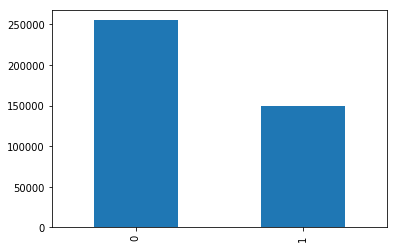

In [46]:
df['is_duplicate'].value_counts().plot(kind = 'bar')
plt.show()

In [47]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   63.08%

~> Question pairs are Similar (is_duplicate = 1):
   36.92%


<h3> 3.2.2 Number of unique questions </h3>

In [48]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Question Pair are: {}\n'.format(unique_qs))

print ('Number of unique question Pair that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values

Total number of  Unique Question Pair are: 537933

Number of unique question Pair that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



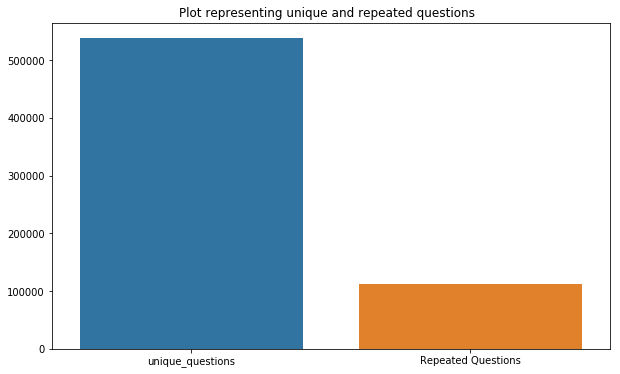

In [49]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

<h3>3.2.3 Checking for Duplicates </h3>

In [52]:
#No Such Duplicates in dataset
df.drop_duplicates(subset = {'qid1','qid2','is_duplicate'},keep = 'first' ,inplace = True)
print(df.shape)

(404290, 6)


<h3> 3.2.4 Number of occurrences of each question </h3>

Maximum number of times a single question is repeated: 157



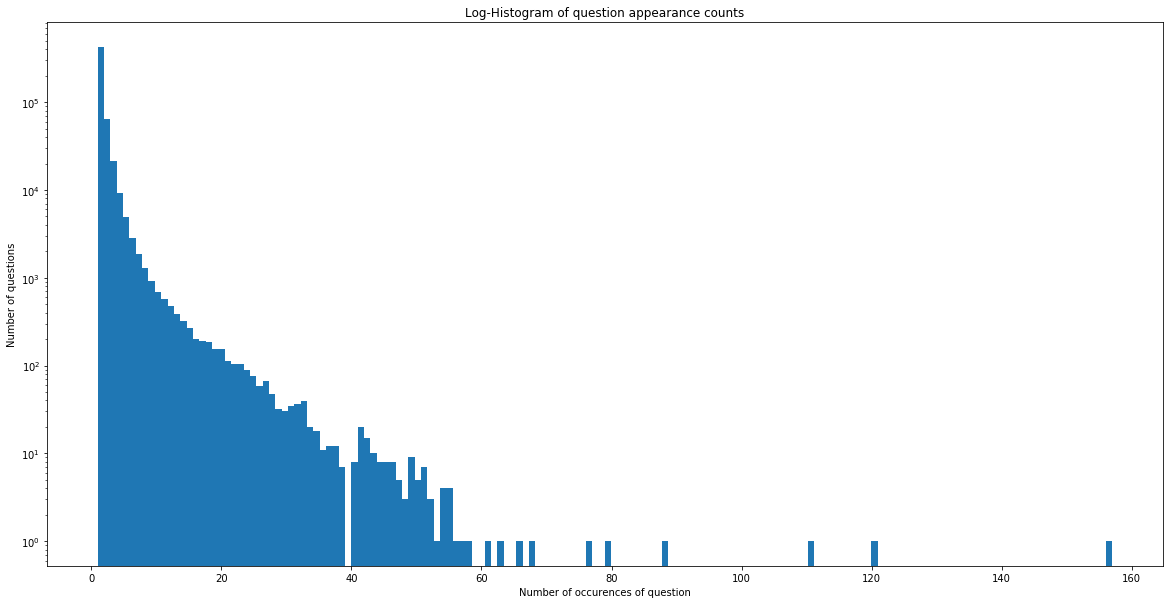

In [57]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

<h3> 3.2.5 Checking for NULL values </h3>

In [66]:
nan_rows = df.iloc[np.where(df.isnull())]
print(nan_rows)

Empty DataFrame
Columns: []
Index: []


In [67]:
# Filling the null values with ' '
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


<h2>3.3 Basic Feature Extraction (before cleaning) </h2>

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [70]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
    df.fillna('')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


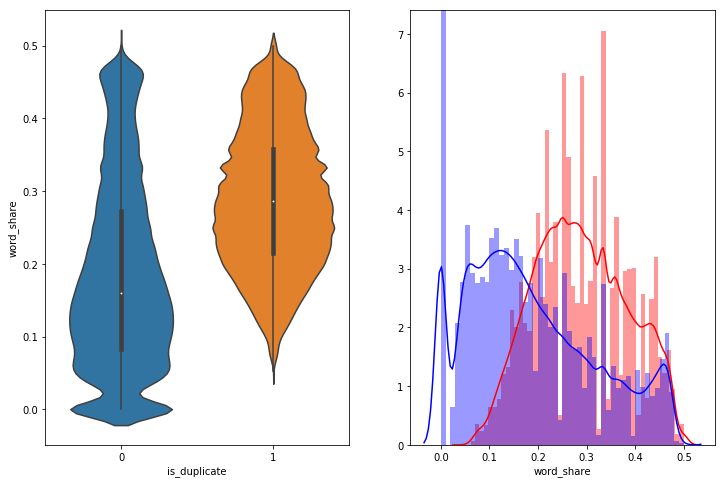

In [76]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df)

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'] , label = "0" , color = 'blue' )
plt.show()

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

<h4> Feature: word_Common </h4>

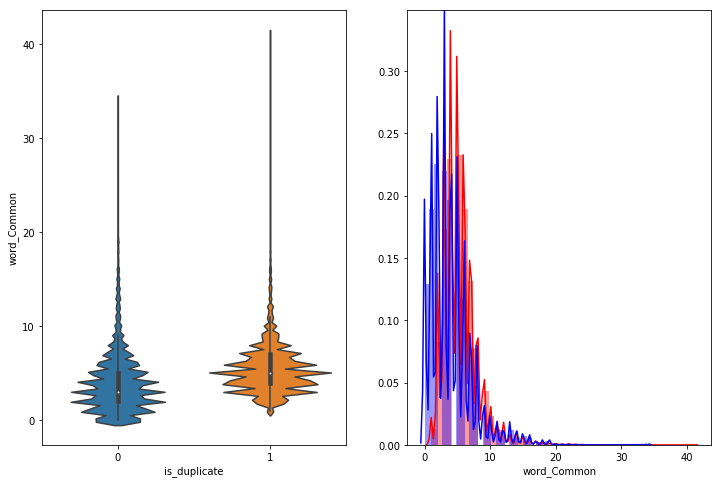

In [77]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df)

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'] , label = "0" , color = 'blue' )
plt.show()

<p> The distributions of the word_Common feature in similar and non-similar questions are highly overlapping </p>

### EDA: Advanced Feature Extraction.


In [85]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin_1',engine = 'python')
    df = df.fillna('')
else:
    print("get df_fe_without_preprocessing_train.csv from drive or run the previous notebook")

In [87]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3


<h2> Preprocessing of Text </h2>

- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [100]:
STOP_WORDS = stopwords.words("english")
def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000","m").replace(",000","k").replace("what's","what is").replace("won't","will not").replace("isn't","is not")\
                            .replace("′", "'").replace("’", "'").replace("n't"," not").replace("cannot","can not").replace("can't","can not")\
                            .replace("'ve"," have").replace("i'm","i am").replace("'re"," are")\
                            .replace("he's","he is").replace("she's","she is").replace("'s"," own")\
                            .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    
    x = re.sub(r"([0-9]+)000000",r"\1m",x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    porter =  PorterStemmer()
    pattern = re.compile("\W")
    
    if type(x) == type(''):
        x = re.sub(pattern,' ',x)
        
    if type(x) == type(''):
        x = porter.stem(x)
        bs4 = BeautifulSoup(x)
        x = bs4.get_text()
    
    return x

- Function to Compute and get the features : With 2 parameters of Question 1 and Question 2

<h2> Advanced Feature Extraction (NLP and Fuzzy Features) </h2>

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [105]:
SAFE_DIV = 0.0001
def get_token_feature(q1,q2):
    token_feature =[0.0]*10
    q1_token = q1.split()
    q2_token = q2.split()
    if len(q1_token) == 0 or len(q2_token) == 0:
        return token_feature
    else:
        q1_word = set([word for word in q1_token if word not in STOP_WORDS])
        q2_word = set([word for word in q2_token if word not in STOP_WORDS])
        q1_stop = set([stop for stop in q1_token if stop in STOP_WORDS])
        q2_stop = set([stop for stop in q2_token if stop in STOP_WORDS])
        
        common_word_count = len(q1_word.intersection(q2_word))
        common_token_count = len(set(q1_token).intersection(set(q2_token)))
        common_stop_count = len(q1_stop.intersection(q2_stop))
        
        token_feature[0] = common_word_count/(min(len(q1_word),len(q2_word)) + SAFE_DIV)
        token_feature[1] = common_word_count/(max(len(q1_word),len(q2_word)) + SAFE_DIV)
        token_feature[2] = common_stop_count/(min(len(q1_stop),len(q2_stop)) + SAFE_DIV)
        token_feature[3] = common_stop_count/(max(len(q1_stop),len(q2_stop)) + SAFE_DIV)
        token_feature[4] = common_token_count/(min(len(q1_token),len(q2_token)) + SAFE_DIV)
        token_feature[5] = common_token_count/(max(len(q1_token),len(q2_token)) + SAFE_DIV)
        
        token_feature[6] = int(q1_token[-1] == q2_token[-1])
        token_feature[7] = int(q1_token[0] == q2_token[0])
        
        token_feature[8] = abs(len(q1_token) - len(q2_token))
        token_feature[9] = (len(q1_token) + len(q2_token))/2
        return token_feature

In [119]:
from difflib import SequenceMatcher
def matchsubstring(m,n): 
    seqMatch = SequenceMatcher(None,m,n) 
    match = seqMatch.find_longest_match(0, len(m), 0, len(n)) 
    if (match.size!=0): 
        return len(m[match.a: match.a + match.size])/(min(len(m), len(n)))  
    else: 
        return 0 

In [120]:
def advance_feature(df):
    df['question1'] = df['question1'].fillna('').apply(preprocess)
    df['question2'] = df['question2'].fillna('').apply(preprocess)
    
    token_feature = df.apply(lambda x : get_token_feature(x['question1'],x['question2']),axis = 1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_feature))
    df["cwc_max"]       = list(map(lambda x: x[1], token_feature))
    df["csc_min"]       = list(map(lambda x: x[2], token_feature))
    df["csc_max"]       = list(map(lambda x: x[3], token_feature))
    df["ctc_min"]       = list(map(lambda x: x[4], token_feature))
    df["ctc_max"]       = list(map(lambda x: x[5], token_feature))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_feature))
    df["first_word_eq"] = list(map(lambda x: x[7], token_feature))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_feature))
    df["mean_len"]      = list(map(lambda x: x[9], token_feature)) 
    
    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    #QRatio ----> Quick Ratio
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x:  matchsubstring(x["question1"], x["question2"]), axis=1)
    return df

In [121]:
if os.path.isfile('nlp_features_train.csv'):
    df = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")
    df = pd.read_csv("train.csv")
    df = advance_feature(df)
    df.to_csv("nlp_features_train.csv", index=False)
df.head(2)

Extracting features for train:


,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,1.000000
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.607843


<h3> Analysis of extracted features </h3>

<h4>  Plotting Word clouds</h4>

- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [259]:
class_1 = df[df['is_duplicate'] == 1]
class_0 = df[df['is_duplicate'] == 0]

positive_qs_pair = np.array([class_1['question1'] , class_1['question2']]).flatten()
negative_qs_pair = np.array([class_0['question1'] , class_0['question2']]).flatten()
 
print ("Number of data points in class 1 (duplicate pairs) :",len(positive_qs_pair))
print ("Number of data points in class 0 (non duplicate pairs) :",len(negative_qs_pair))

stopword = set(STOP_WORDS)
stopword.add('said')
stopword.add('br')
stopword.add(' ')

stopword.remove('not')
stopword.remove('no')
stopword.add("what'")
stopword.add("how'")
stopword.add("is'")
stopword.add("do'")
#stopword.remove('like')
#print(stopword)

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


__ Word Clouds generated from  duplicate pair question's text __

Word Cloud for Duplicate Question pairs


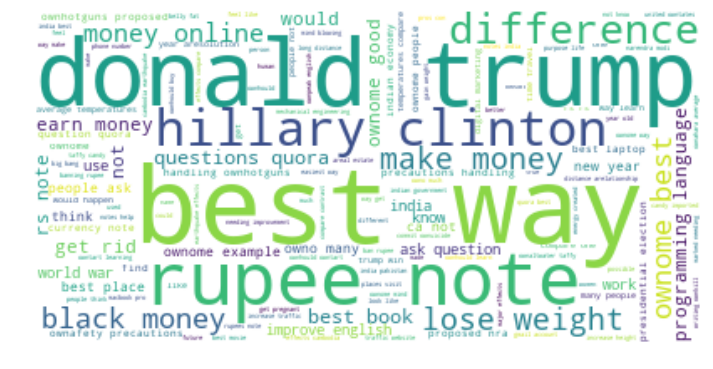

In [261]:
positive = []
for i in positive_qs_pair:
    x = i.split()
    for j in range(len(x)):
        if (x[j].isalpha()) : 
            if type(x[j]) is type(''):
                positive.append(x[j])
wc = WordCloud(background_color="white", max_words = len(positive), stopwords=stopword)
positive = preprocess(positive)
wc.generate(str(positive))
print ("Word Cloud for Duplicate Question pairs")
plt.figure(figsize=(12, 12))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

__ Word Clouds generated from non duplicate pair question's text __

Word Cloud for Duplicate Question pairs


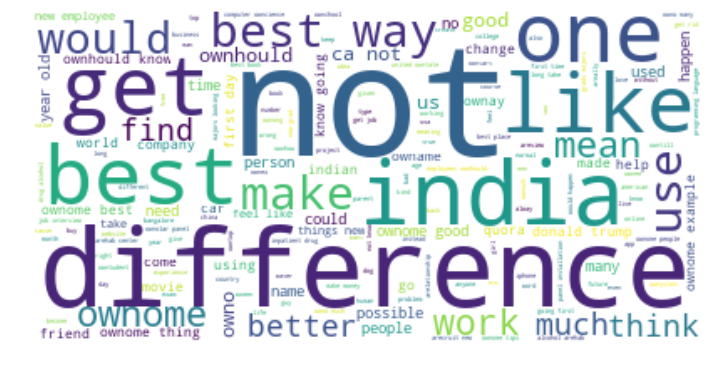

In [263]:
negative = []
for i in negative_qs_pair:
    x = i.split()
    for j in range(len(x)):
        if (x[j].isalpha()) : 
            if type(x[j]) is type(''):
                negative.append(x[j])
wc = WordCloud(background_color="white", max_words = len(negative), stopwords=stopword)
negative = preprocess(negative)
wc.generate(str(negative))
print ("Word Cloud for Duplicate Question pairs")
plt.figure(figsize=(12, 12))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

<h4> Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'] </h4>

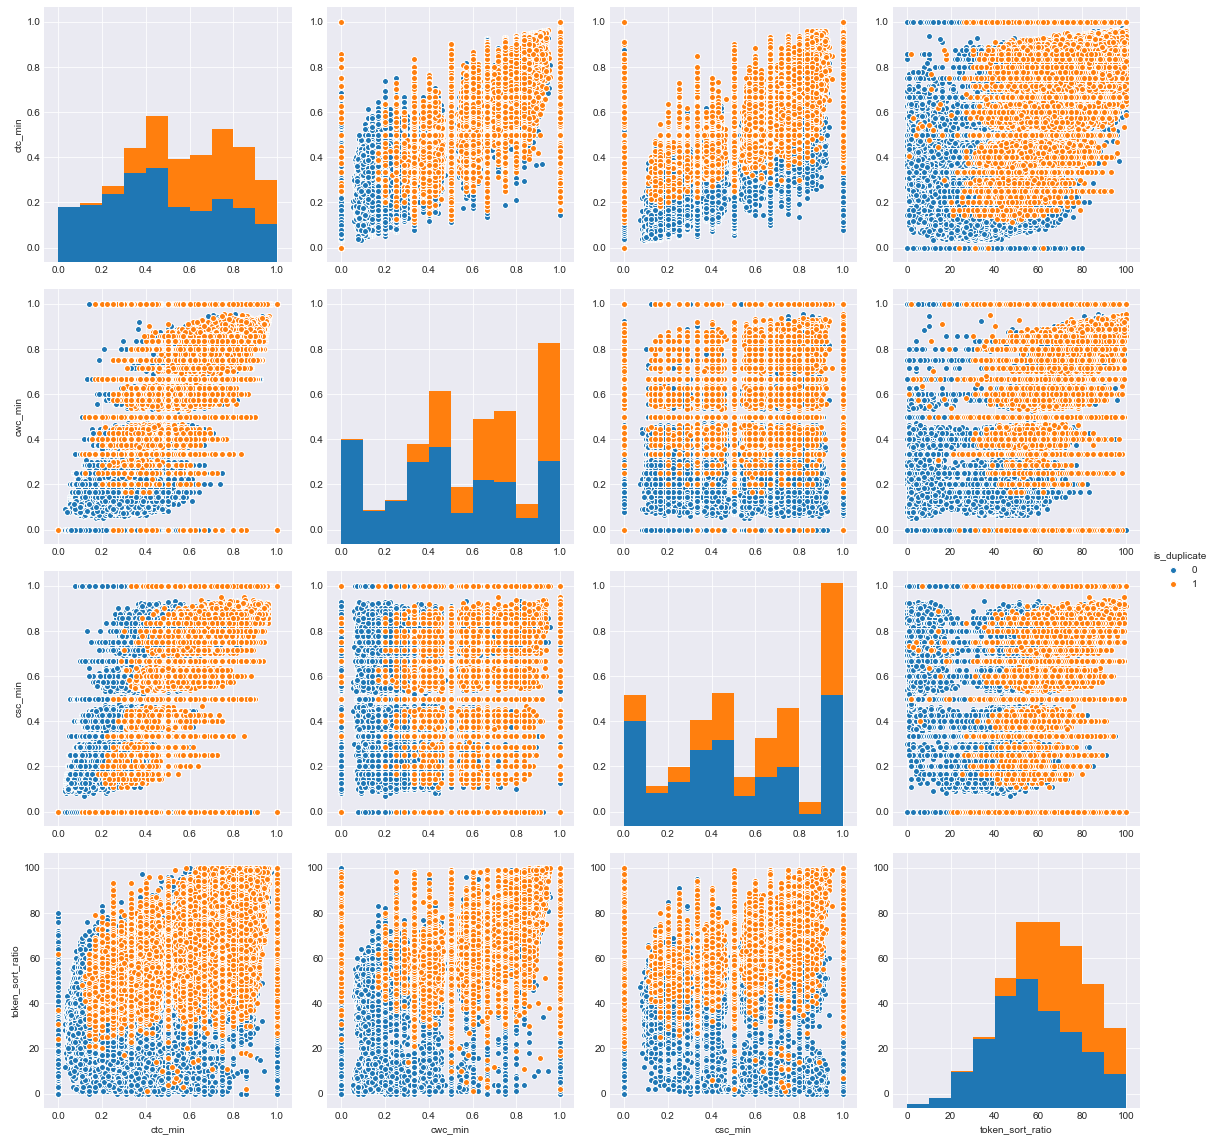

In [270]:
plt.close()
sns.set_style('darkgrid')
sns.pairplot(data = df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio','is_duplicate']],vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'], hue = 'is_duplicate' , size  = 4)
plt.show()

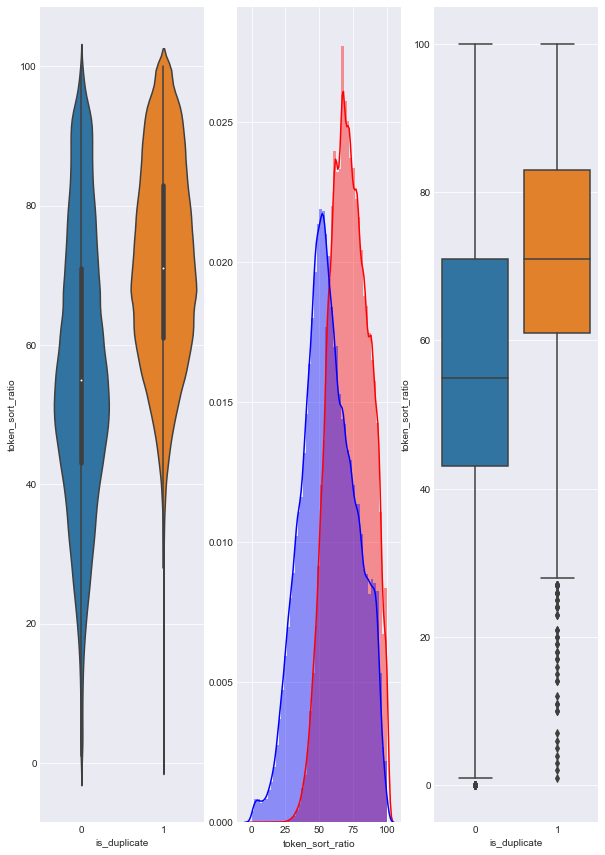

In [275]:
plt.figure(figsize=(10, 15))

plt.subplot(1,3,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df)

plt.subplot(1,3,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'] , label = "0" , color = 'blue' )

plt.subplot(1,3,3)
sns.boxplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df)
plt.show()

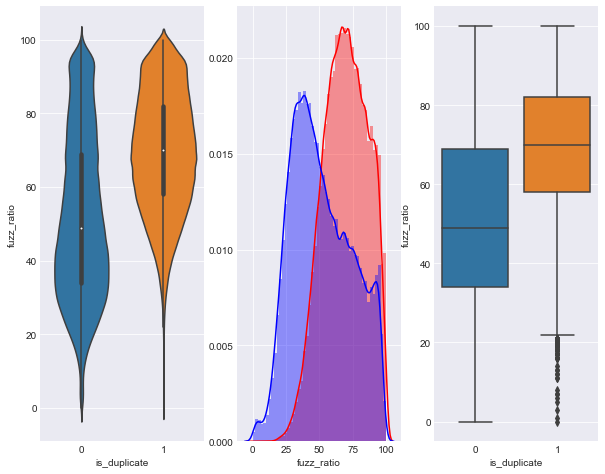

In [276]:
plt.figure(figsize=(10, 8))

plt.subplot(1,3,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df)

plt.subplot(1,3,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'] , label = "0" , color = 'blue' )

plt.subplot(1,3,3)
sns.boxplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df)
plt.show()

In [277]:
from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [278]:
tsne2d = TSNE(
    n_components=2,
    init='random',#default
    random_state=101,
    method='barnes_hut',#default
    n_iter=1000,#default
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.058s...
[t-SNE] Computed neighbors for 5000 samples in 0.520s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130781
[t-SNE] Computed conditional probabilities in 0.342s
[t-SNE] Iteration 50: error = 81.2424240, gradient norm = 0.0462601 (50 iterations in 9.863s)
[t-SNE] Iteration 100: error = 70.6049881, gradient norm = 0.0099202 (50 iterations in 6.731s)
[t-SNE] Iteration 150: error = 68.9059601, gradient norm = 0.0057159 (50 iterations in 6.456s)
[t-SNE] Iteration 200: error = 68.1044769, gradient norm = 0.0041706 (50 iterations in 6.863s)
[t-SNE] Iteration 250: error = 67.6028976, gradient norm = 0.0041267

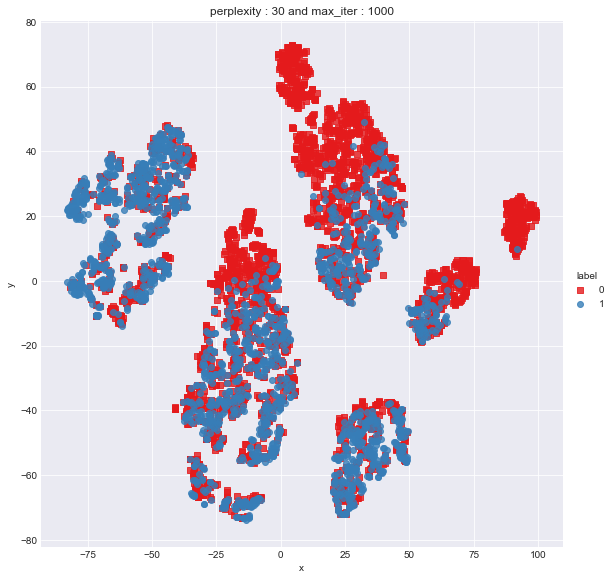

In [280]:
df_tsne_2d = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df_tsne_2d, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [281]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.016s...
[t-SNE] Computed neighbors for 5000 samples in 0.516s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130781
[t-SNE] Computed conditional probabilities in 0.262s
[t-SNE] Iteration 50: error = 80.4752350, gradient norm = 0.0326151 (50 iterations in 18.903s)
[t-SNE] Iteration 100: error = 69.3851929, gradient norm = 0.0036226 (50 iterations in 9.194s)
[t-SNE] Iteration 150: error = 67.9767609, gradient norm = 0.0016960 (50 iterations in 8.059s)
[t-SNE] Iteration 200: error = 67.4179535, gradient norm = 0.0011948 (50 iterations in 8.127s)
[t-SNE] Iteration 250: error = 67.1090927, gradient norm = 0.000871

In [283]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

df_tsne_3d=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=go.Figure(data=df_tsne_3d, layout=layout)
py.iplot(fig, filename='3DBubble')

# Conclusion

* We have constructed some basic features without preprocessing  and some advance features with preprocessing from the question1 and question2.
- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs.
- We can observe the most frequent occuring words.
* Using TSNE for Visulization of 15 Features(Generated after cleaning the data) to 2 dimension and 3 dimention.